# **Data Science projet SS2021**

Author: **Robin Ringwald**

course of study: **MMR**

Topic: **Retail Product Categorisation**

Kaggle name: **Rob Top**

Kaggle score: **0.82764**


This notebook is created for the Data Science project in summer 2021. It is oriented mostly on the workflow from the lecture seen below and based on the given solution.

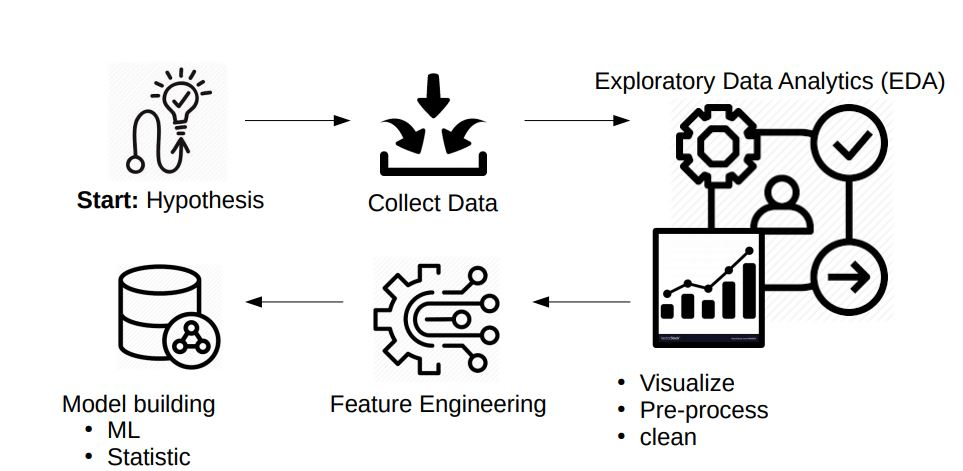

In [ ]:
#from IPython.display import Image
#Image('DataScience_Workflow.JPG')

# 0 Hypothesis



The project deals with a Kaggle competition created specifically for the lecture. This competition is for product classification based on pictures and descriptions of the products.
The data is made available in the Kaggle competition. It is planned to carry out the project in Colab with the help of a GPU.

Have a look at current GPU in Colab

In [1]:
!nvidia-smi

Tue Aug 10 13:42:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 Collect Data

## 1.1 Import the necessary libraries and make initializations

In [2]:
! pip install keras_metrics
! pip install tabulate

In [3]:
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd #needed for value handling
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')  #commonly used words
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
%matplotlib inline
from IPython.display import display
from tabulate import tabulate

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2 Import the competition Data from Kaggle

Upload kaggle.json to colab from local computer and copy to root directory.

Detailed guide: https://www.kaggle.com/general/74235

In [4]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


load Data set from Kaggle and unzip it to colab directory.

In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle &> /dev/null   # &> /dev/null hides the cell-output of this line, errors that may rise, still will be shown
! kaggle datasets list &> /dev/null
! kaggle competitions download -c 'retail-products-classification'
! mkdir retail-products-classification &> /dev/null
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null

retail-products-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


## 1.3 Read and Prepare Data

Read the train.csv file 

In [6]:
data = pd.read_csv('retail-products-classification/train.csv')

List of classes

Parameters

In [7]:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']

In [8]:
train_images_path = 'retail-products-classification/train/train'
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 30
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

Preparation to download the images for the train dataset

In [9]:
downloaded_files = []
for file in os.listdir(train_images_path):
    if file.endswith(".jpg"):
        downloaded_files.append(file.replace(".jpg", ""))
print(len(downloaded_files))

42000


In [10]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

# 2 Exploratory Data Analytics

## 2.1 Visualize

Visualize some Data itself and some images. Additionally visualize some information about the Dataset to get it better known.



### 2.1.1 Visualize some data

As always, first have a look at the header of the dataset. The header gives a good first overview of the data we are facing.

In [ ]:
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


In [ ]:
print(tabulate(data['categories'].value_counts().to_frame(),headers=["categories", "Number of items"], tablefmt='fancy_grid'))

# Alternatives

#data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));
#data['categories'].value_counts().to_frame()#.columns=["categories", "Number of items"]


╒═══════════════════════════╤═══════════════════╕
│ categories                │   Number of items │
╞═══════════════════════════╪═══════════════════╡
│ Arts, Crafts & Sewing     │              2225 │
├───────────────────────────┼───────────────────┤
│ Beauty                    │              2202 │
├───────────────────────────┼───────────────────┤
│ Grocery & Gourmet Food    │              2201 │
├───────────────────────────┼───────────────────┤
│ Sports & Outdoors         │              2201 │
├───────────────────────────┼───────────────────┤
│ Tools & Home Improvement  │              2200 │
├───────────────────────────┼───────────────────┤
│ Appliances                │              2200 │
├───────────────────────────┼───────────────────┤
│ Patio, Lawn & Garden      │              2200 │
├───────────────────────────┼───────────────────┤
│ Clothing, Shoes & Jewelry │              2200 │
├───────────────────────────┼───────────────────┤
│ Cell Phones & Accessories │              2200 │


### 2.1.2 Visualize some Images of the Data set

In [ ]:
from PIL import Image
import glob
image_list = []
for filename in glob.glob('retail-products-classification/train/train/*.jpg'): #assuming .jpg
    im=Image.open(filename)
    image_list.append(im)

iterations:  30


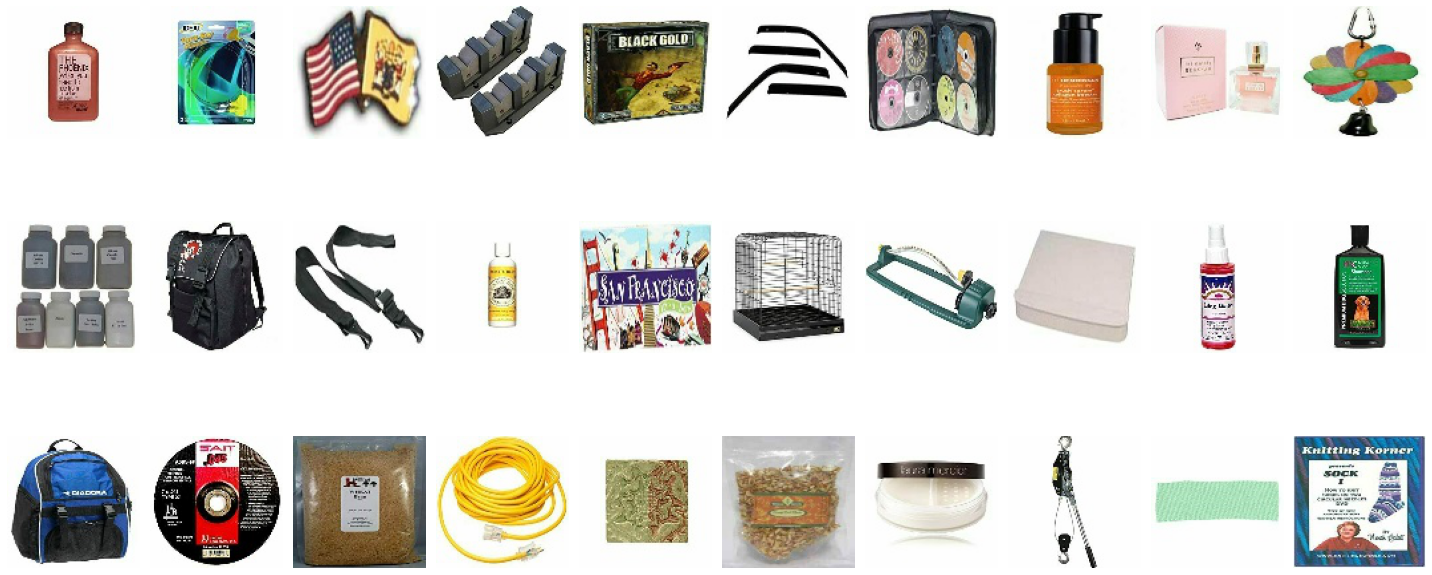

In [ ]:
j = 1   # counter for loop iterations
rows = 3
columns = 10
stepsize = 1000

fig = plt.subplots(rows, columns, figsize=(20,10))

# eventuell noch die jeweilige Kategorie als title
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image_list[i])
    j += 1

plt.tight_layout()
print('iterations: ', j-1)

### 2.1.3 Visualize some information about the Data set

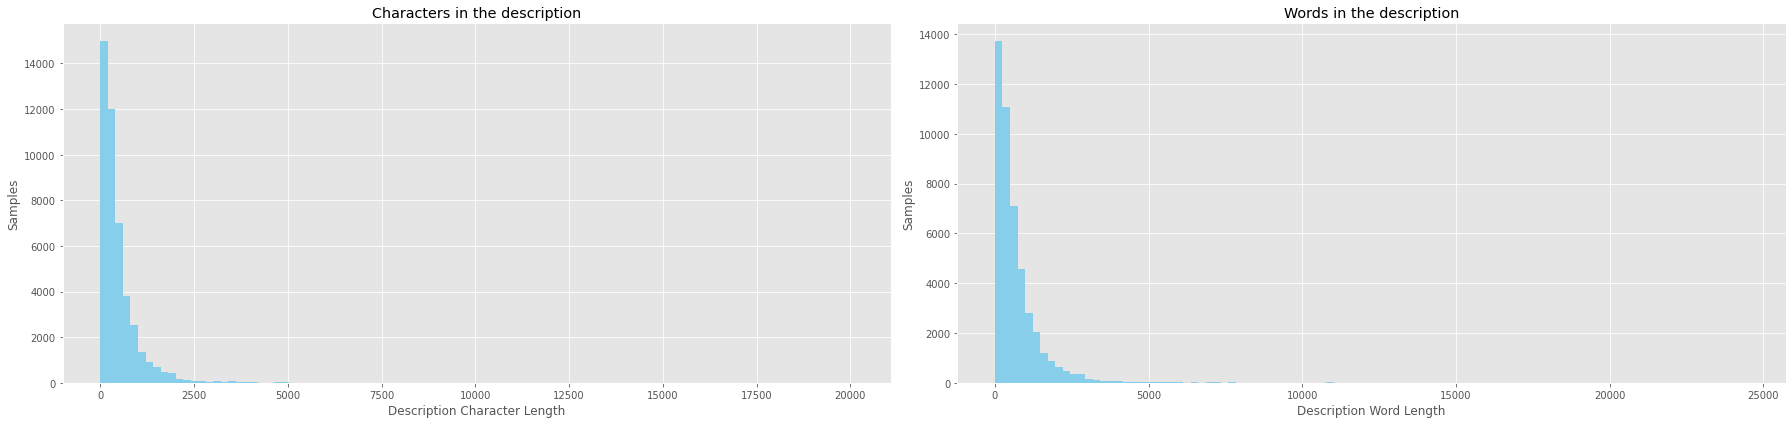

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(25, 6))


word_len=data['description'].str.len()
axs[0].hist(word_len, bins=100, color = "skyblue")
axs[0].set_ylabel('Samples')
axs[0].set_xlabel('Description Character Length')
axs[0].set_title('Characters in the description')


word_len=data['description'].str.split().map(lambda x: len(str(x)))
axs[1].hist(word_len, bins=100, color = "skyblue")
axs[1].set_ylabel('Samples')
axs[1].set_xlabel('Description Word Length')
axs[1].set_title('Words in the description')


plt.tight_layout()

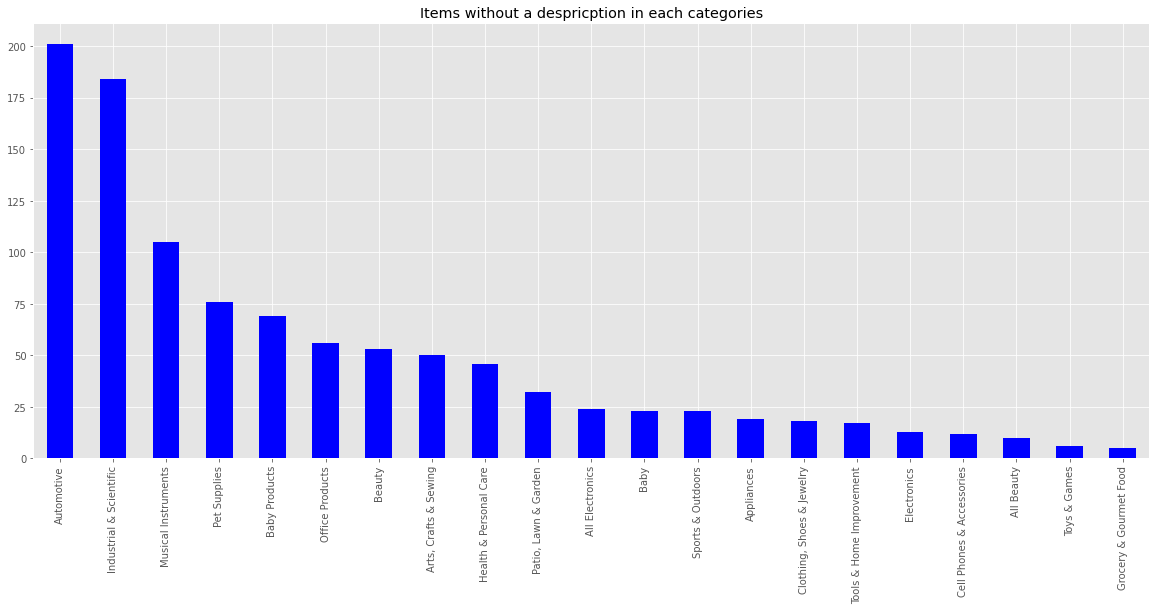

In [ ]:
d_NaN = data[data['description'].isnull()]
d_NaN['categories'].value_counts().plot(kind='bar',figsize=(20,8),color='blue', title='Items without a despricption in each categories')

### 2.1.4 Conclusion of visualization




*   One Data set got an Image ID, title, description and the categorie
*   The categories have all about the same number of products
*   A small percentage of the products have a very long description
*   There are items in each category without a description
*   

Approach: 
 

*   Pre-process the description and remove redundant information and reduce it to a minimum.
*   Normalize the images, to same format.








## 2.2 Pre-process

Clean the text data and normalize the images.

### 2.2.1 Text preprocessing

In [11]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        return tokens

Filter special characters from the description, such as numbers and special characters.
In Addition convert all characters to lower case.

Remove words with less then 2 characters and english stop words such as: i, me, myself, we...

In [12]:

def filter_description (text_data):
    data_words = tf.keras.preprocessing.text.text_to_word_sequence(
          text_data,
          filters='!"#$%&()*+,-./:;\<=>?@[\\]^_`{|}~\t\n1234567890',
          lower=True,
          split=' ' 
        )
    #filter short words with less then 2 characters
    data_words = [i for i in data_words if(len(i) > 2)]
    # Remove stop words
    data_words = [s for s in data_words if s not in stop_english]
    #Just use the first 250 Words of the description
    del data_words[256:]
    # Put the single words back in sentences
    listToStr = ' '.join([str(elem) for elem in data_words])
     #put the strings together
    filters="',"
    for x in range(len(filters)):
        text_fil= listToStr.replace(filters[x],"")
    #return data_words  
    return text_fil

### 2.2.2 Image preprocessing

In [13]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

### 2.2.3 Read product images
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category.

In [14]:
corpus = []
images = []
labels = []
image_id = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [15]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

### FastText pretrained vectors
[Download](https://fasttext.cc/docs/en/crawl-vectors.html) and load FastText pretrained vectors. Otherwise use the gensim to load the fasttext model. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. Then initilize the embedding matrix with fastText word vectors.

In [20]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)
        

KeyboardInterrupt: ignored

In [ ]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext

# 3 Model building

## 3.1 Text Classification

### 3.1.1 BERT Text Classification

based on Tensorflow Example:

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb

In [ ]:
# via BERT


# preparation BERT
!pip install -q -U tensorflow-text
!pip install -q tf-models-official


import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 4.3 MB 12.5 MB/s 
     |████████████████████████████████| 1.6 MB 10.9 MB/s 
     |████████████████████████████████| 679 kB 45.5 MB/s 
     |████████████████████████████████| 99 kB 8.8 MB/s 
     |████████████████████████████████| 211 kB 42.2 MB/s 
     |████████████████████████████████| 636 kB 42.8 MB/s 
     |████████████████████████████████| 1.2 MB 41.2 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
     |████████████████████████████████| 90 kB 9.7 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 352 kB 43.4 MB/s 


#### Create Dataset for BERT model

In [ ]:
#duration approx. 3 min
corpus = []
images = []
labels = []
image_id = []
#get a list of all files in the directory
files = os.listdir(train_images_path)
random.shuffle(files)

#iterate trough every single image in the list files
for img in files:
    #get the id of the image by removing the .jpeg
    img_id = img.split('.')[0]
    #create the image(size 80x80, rgb, convert into array)
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            #read the data of the image in the row with the image id
            index = data[data['ImgId']==img_id].index.values[0]
            #write the data into row
            row = data.iloc[index , :]
            #family = category of the image
            family = row[3]
            #if the family of the products is in the define categories
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                #adds an item to the end of the list images
                images.append(img_array.astype('float32'))
                #get a list with all tokens (words) in the description and title, own prefiltering 
                token_list = filter_description(str(title) + ' ' + str(description))#changed
                #adds the words of the current token_list to the corpus (Textsammlung)
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
                image_id.append(index)
        except IndexError as error:
            print(error)

#converting
#corpus = alle Beschreibungen 
images = np.asarray(images)
labels = pd.get_dummies(labels).values  #on hot encoded labels
images = preprocess_input(images)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [ ]:
#Train test Split:
p = int((len(image_id)*80)/100)

#train data
train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
#test data
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

print('train data:',len(train_data_raw))
print('train labels:',len(train_labels_onehot))
print('test data:',len(test_data_raw))
print('test_labels:',len(test_labels_onehot))

train data: 33600
train labels: 33600
test data: 8400
test_labels: 8400


In [ ]:
#create a Dataset, shuffel and prefetch it, to speed up the training
train_ds = tf.data.Dataset.from_tensor_slices((train_data_raw,train_labels_onehot))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_data_raw,test_labels_onehot))
test_ds = test_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Already tested BERT-models:


*   small_bert/bert_en_uncased_L-4_H-512_A-8 (duration per epoch: approx. **5.5 min.**, result: **good**)

    Duration very much depends on the GPU, which is provided by Colab.

    *   Tesla K80: 7.5 min. per epoch
    *   Tesla P100: 5.5 min per epoch


    

    

*   Listeneintrag






In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


#### The preprocessing mode

Test preprocessing

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


#### Using the BERT model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626282   0.9928099  -0.18611862  0.3667383   0.15233758  0.655044
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842764 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946292  0.34321183  0.33231512 ...  0.21300802  0.7102092
  -0.05771042]
 [-0.28741995  0.31980985 -0.23018652 ...  0.5845511  -0.21329862
   0.72692007]
 [-0.6615692   0.68876815 -0.8743301  ...  0.1087728  -0.26173076
   0.47855455]
 ...
 [-0.22561137 -0.2892573  -0.07064426 ...  0.47566032  0.8327724
   0.40025347]
 [-0.2982421  -0.27473164 -0.05450544 ...  0.4884972   1.0955367
   0.18163365]
 [-0.4437818   0.00930662  0.07223704 ...  0.17290089  1.1833239
   0.07897975]]


#### Define your model

Model for use only with text classification

In [ ]:
# very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(21, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
# Let's check that the model runs with the output of the preprocessing model.

BERT_Text_classification_model = build_classifier_model()
bert_raw_result = BERT_Text_classification_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor(
[[0.3296469  0.46518084 0.6225756  0.36205718 0.29499212 0.6330871
  0.50600195 0.32481635 0.70653784 0.3681386  0.5949935  0.18574266
  0.635616   0.15611109 0.76852125 0.76454586 0.62320024 0.4153532
  0.68020284 0.67334676 0.23789442]], shape=(1, 21), dtype=float32)


Model for use with another model for image classification to combine both

In [ ]:
def build_BERT_classifier():
      text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
      preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing',trainable=False)
      encoder_inputs = preprocessing_layer(text_input)
      encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
      outputs = encoder(encoder_inputs)
      net = outputs['pooled_output']
      net = tf.keras.layers.Dropout(0.2)(net)
      net = tf.keras.layers.Dense(2048,activation='relu')(net)
      return tf.keras.Model(text_input, net)

In [ ]:
BERT_model = build_BERT_classifier()
BERT_model.summary()

#### Model Structure

In [ ]:
BERT_Text_classification_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
preprocessing (KerasLayer)      {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
BERT_encoder (KerasLayer)       {'default': (None, 5 28763649    preprocessing[0][0]              
                                                                 preprocessing[0][1]              
                                                                 preprocessing[0][2]              
______________________________________________________________________________________________

Print the Layout of the current defined BERT-model as a flowchart

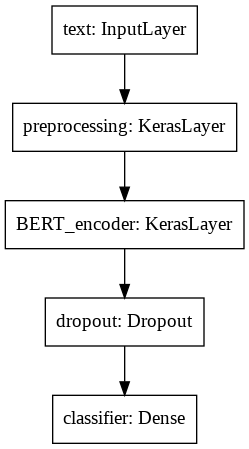

In [ ]:
tf.keras.utils.plot_model(BERT_Text_classification_model)

#### Model Training

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()


Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as AdamW.

For the learning rate (init_lr), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (num_warmup_steps). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).


In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
BERT_Text_classification_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = BERT_Text_classification_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
1050/1050 [==============================] - 464s 435ms/step - loss: 0.2029 - binary_accuracy: 0.9420 - val_loss: 0.0900 - val_binary_accuracy: 0.9680
Epoch 2/10
1050/1050 [==============================] - 456s 434ms/step - loss: 0.0756 - binary_accuracy: 0.9730 - val_loss: 0.0643 - val_binary_accuracy: 0.9775
Epoch 3/10
1050/1050 [==============================] - 455s 434ms/step - loss: 0.0526 - binary_accuracy: 0.9814 - val_loss: 0.0573 - val_binary_accuracy: 0.9809
Epoch 4/10
1050/1050 [==============================] - 457s 435ms/step - loss: 0.0396 - binary_accuracy: 0.9863 - val_loss: 0.0553 - val_binary_accuracy: 0.9821
Epoch 5/10
1050/1050 [==============================] - 456s 434ms/step - loss: 0.0301 - binary_accuracy: 0.9899 - val_loss: 0.0549 - val_binary_accuracy: 0.9830
Epoch 6/10
1050/1050 [==============================] - 457s 436ms/step - loss: 0.0232 - binary_ac

#### Results on  Text Classification with just BERT

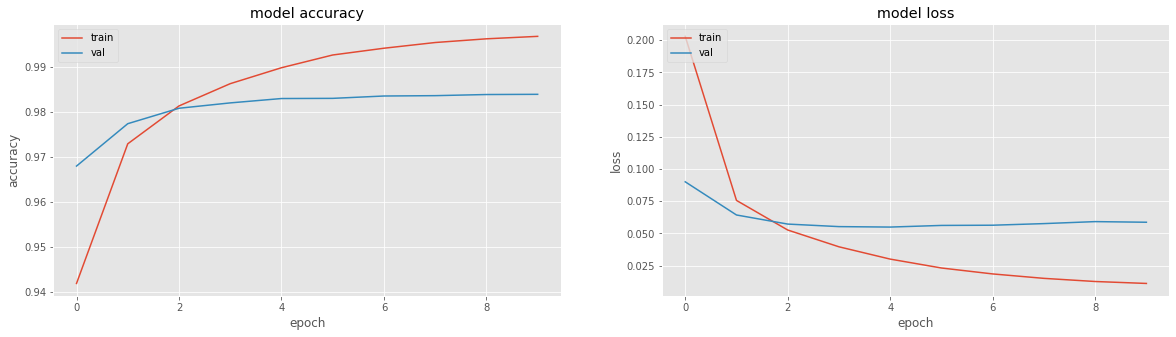

In [ ]:
history_bert = history.history
fig, axes = plt.subplots(1, 2, figsize=(20,5))

#Plot the accuracy
axes[0].plot(history_bert['binary_accuracy'])
axes[0].plot(history_bert['val_binary_accuracy'])
axes[0].set_title('model accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['train', 'val'], loc='upper left')


#Plot the loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('model loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['train', 'val'], loc='upper left')

Create Submission File

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head()

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(filter_description(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
AUTOTUNE = tf.data.AUTOTUNE

test_ds_submission = tf.data.Dataset.from_tensor_slices(test_corpus)
test_ds_submission = test_ds_submission.batch(BATCH_SIZE)
test_ds_submission = test_ds_submission.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
pred_submission = BERT_Text_classification_model.predict(test_ds_submission)
test_classes = np.argmax(pred_submission, axis = 1)
print(test_classes)
print(test_classes.shape)

[ 1 12  8 ...  6 10  6]
(6367,)


In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])

### 3.2.2 LSTM Net Text Classification

In [ ]:
# Original model from base solution

#embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN,trainable=False)

#dropout = tf.keras.layers.SpatialDropout1D(0.2)
##lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
##lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
#lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
#dense = tf.keras.layers.Dense(200, activation='relu')
#embedding_model = tf.keras.Sequential([
#    embedding_layer,
#    dropout,
#    lstm,
#    dense 
#])
#embedding_model.summary()'


## 3.2 Image Classification

### 3.2.1 MobileNet

In [ ]:
# Original model from base solution
input_tensor = Input(shape=INPUT_SHAPE)
MobileNet_Image_classification_model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(MobileNet_Image_classification_model.output)
output = tf.keras.layers.Dense(100, activation='relu')(output)
MobileNet_Image_classification_model.summary()

Model: "mobilenet_1.00_None"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 40, 40, 32)

### 3.2.2 Sequential Keras

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
num_classes = 5

Sequential_keras_model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## 3.3 Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

In [ ]:
del final_model

NameError: ignored

In [ ]:
# BERT and MobileNet

merged = tf.keras.layers.Concatenate()([BERT_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense1)

final_model = tf.keras.Model(inputs=[BERT_model.input, MobileNet_Image_classification_model.input], outputs=output_layer)

In [ ]:
# BERT and Sequential Keras

merged = tf.keras.layers.Concatenate()([BERT_Text_classification_model.output, Sequential_keras_model.output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense1 = tf.keras.layers.Dense(100, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense1)

final_model = tf.keras.Model(inputs=[BERT_Text_classification_model.input, Sequential_keras_model..input], outputs=output_layer)

SyntaxError: ignored

In [ ]:
# Original from base solution

#merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

#normalize = tf.keras.layers.BatchNormalization()(merged)

#final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

#dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

#output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

#final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [ ]:
final_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 40, 40, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 40, 40, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 40, 40, 32)   0           conv1_bn[0][0]                   
___________________________________________________________________________________________

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## 3.4 Create test and training Data
Split the complete dataset into 80% data for training and 20% for test.

In [ ]:
#Image Data
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]


#Text Data
train_data_raw = corpus[:p]
train_labels_onehot = labels[:p]
test_data_raw = corpus[p:]
test_labels_onehot = labels[p:]

text_train = np.asarray(train_data_raw)
text_test = np.asarray(test_data_raw)

In [ ]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600,)


## 3.5 Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
final_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

## 3.6 Train the final model
Train the final model, which is concaneted of two models, one for image classification and one for text classification.

Depending on which models were concanetad in the previous steps.

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([ text_train,image_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([text_test, image_test], label_test))
except RuntimeError as e:
  print(e)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer.py:1307: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


1050/1050 [==============================] - 554s 519ms/step - loss: 3.1064 - accuracy: 0.0699 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.0255 - val_accuracy: 0.0942 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
 387/1050 [==========>...................] - ETA: 4:50 - loss: 2.9283 - accuracy: 0.0970 - precision: 0.0000e+00 - recall: 0.0000e+00

In [ ]:
#final_model.save_weights("saved_model/weights.h5")
#final_model.load_weights("static/weights.h5")

# 4 Statisitc and evaluation

## 4.1 Make predictions on validation data

In [ ]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

8400/8400 - 118s


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm = confusion_matrix(y_test, classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.335


Text(0.5, 114.0, 'Predicted label')

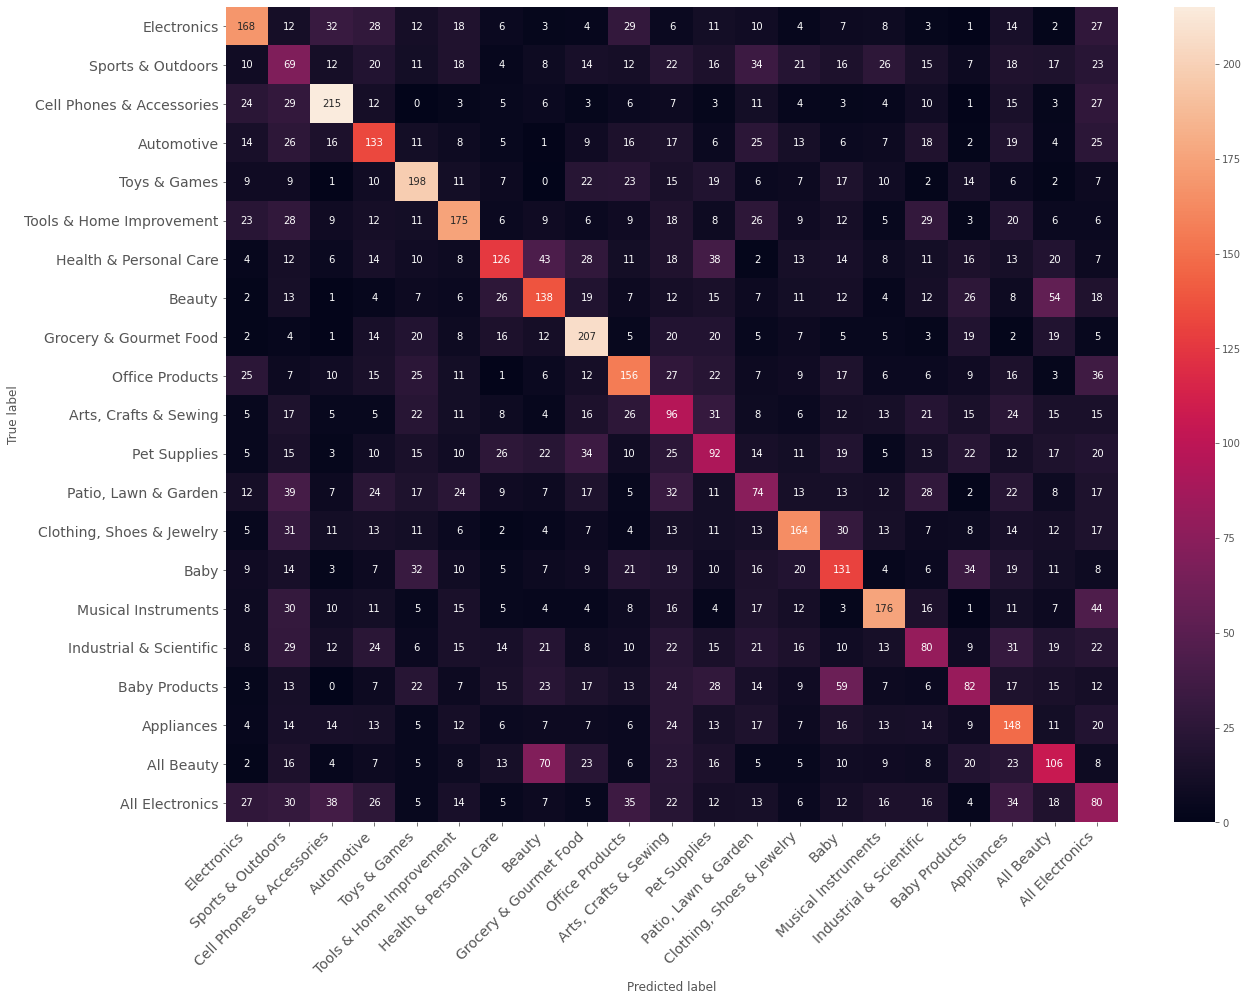

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

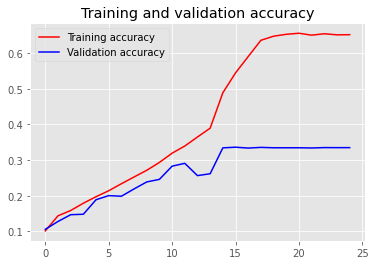

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

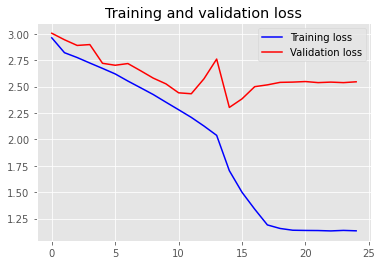

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 4.2 Extract and visualize embedding

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

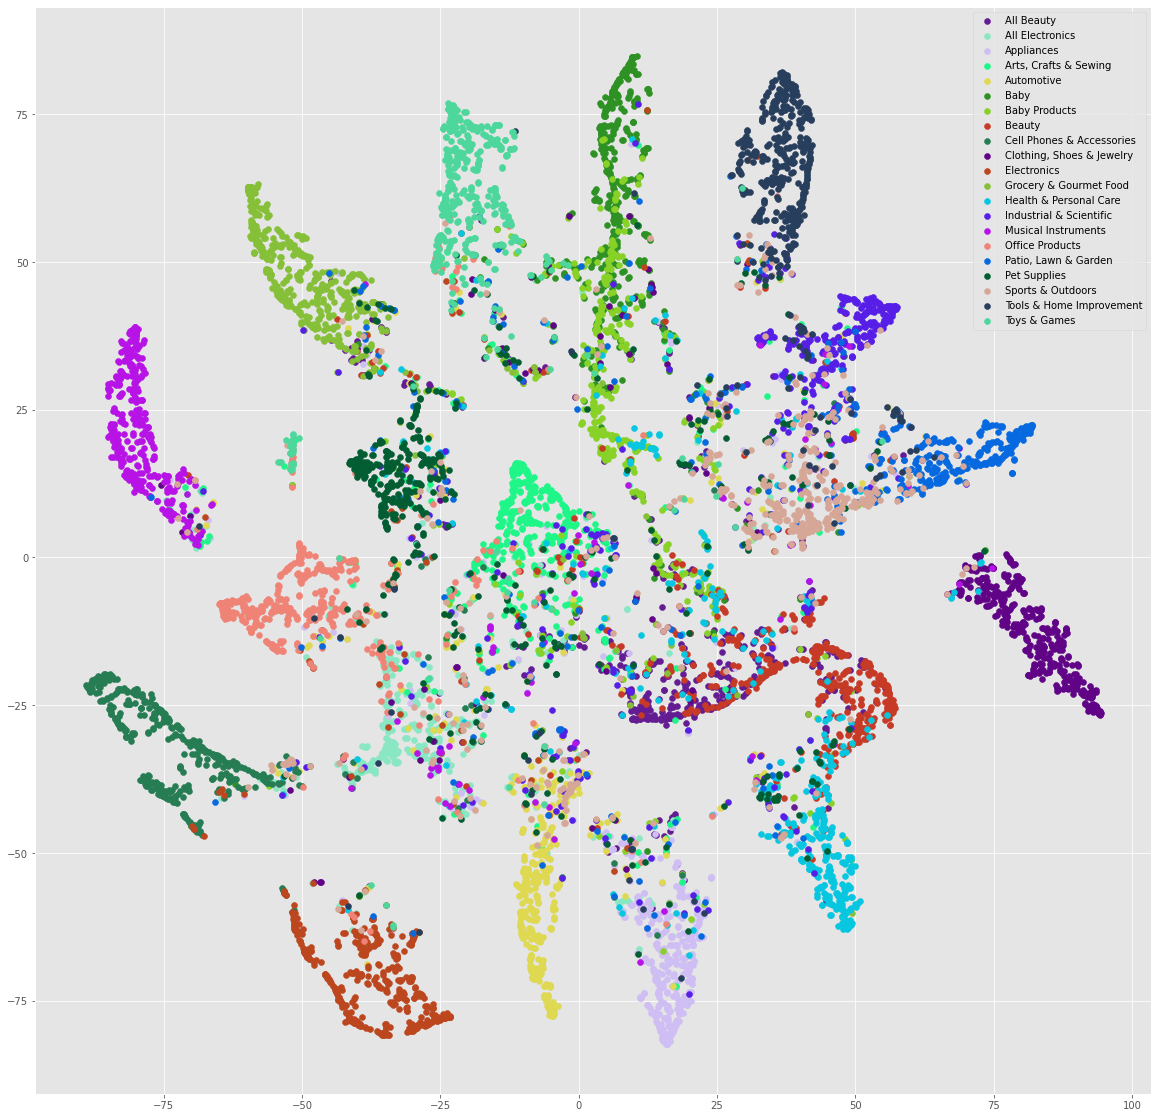

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

## 4.3 Read the test data

In [ ]:
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

# 5 Submission


## 5.1 Make predictions on test data

In [ ]:
pred = final_model.predict([test_images, test_pad],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 89s


## 5.2 Create submission file

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])